In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from patsy import dmatrices
wd = "/Users/timvigers/Documents/Work/Viral Shah/ADA 2022/"

In [11]:
# Import Kaan's data
df = pd.read_csv(wd + "Data_Clean/analysis_data.csv",usecols=["14 Day Mean","HbA1c"])
# Only HbA1c < 6.5
df = df[df["HbA1c"] < 6.5]
df.columns = ["HbA1c","MBG"]
df = df[["MBG","HbA1c"]]
df["MBG"] = [round(m,2) for m in df["MBG"]]
# Add JAEB data
jaeb_cgm = pd.read_csv(wd + "Data_Raw/CGMND/NonDiabDeviceCGM.csv")
jaeb_cgm = jaeb_cgm[jaeb_cgm["RecordType"] == "CGM"]
# Split by ID
dataframes = []
for _, d in jaeb_cgm.groupby(["PtID"]):
    dataframes.append(d)
# Calculate mean glucose for each participant
mean_bgs = {"PtID":[],"MBG":[]}
for d in dataframes:
    mean_bgs["PtID"].append(d["PtID"].iloc[0])
    mean_bgs["MBG"].append(round(d["Value"].mean(),2))
mean_bgs = pd.DataFrame(mean_bgs)
# Add HbA1c
jaeb_a1c = pd.read_csv(wd + "Data_Raw/CGMND/NonDiabScreening.csv",usecols=["PtID","HbA1c"])
jaeb_a1c["PtID"] = [str(p) for p in jaeb_a1c["PtID"]]
mean_bgs["PtID"] = [str(p) for p in mean_bgs["PtID"]]
mean_bgs = mean_bgs.merge(jaeb_a1c,on = "PtID",how="left")
mean_bgs = mean_bgs[["MBG","HbA1c"]]
# Combine
df = pd.concat([df,mean_bgs])
# Calculate GMI
df["GMI"] = [3.31 + 0.02392*m for m in df["MBG"]]
df["Diff"] = df["HbA1c"] - df["GMI"]

# Mean Glucose and HbA1c
Red line indicates GMI regression line.

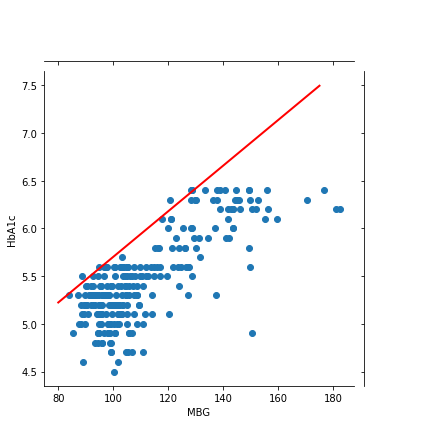

In [33]:
grid = sns.JointGrid(x=df["MBG"],y=df["HbA1c"])
grid.plot_joint(plt.scatter)
plt.plot([80,175],[5.2236,7.496], linewidth=2, color = "r");

# Regression Results

In [46]:
outcome, predictors = dmatrices("HbA1c ~ MBG", df)
reg = OLS(outcome,predictors).fit()

In [49]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  HbA1c   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     397.2
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           2.80e-54
Time:                        15:19:16   Log-Likelihood:                -44.591
No. Observations:                 262   AIC:                             93.18
Df Residuals:                     260   BIC:                             100.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4551      0.102     33.854      0.000       3.254       3.656
MBG            0.0180      0.001     19.930      0.000       0.016       0.020
==============================================================================
Omnibus:                       19.822   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.189
Skew:                          -0.564   Prob(JB):                     3.39e-06
Kurtosis:                       4.017   Cond. No.                         647.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on this dataset, the regression equation for GMI would be:

GMI = 3.4551 + 0.0180 * MBG

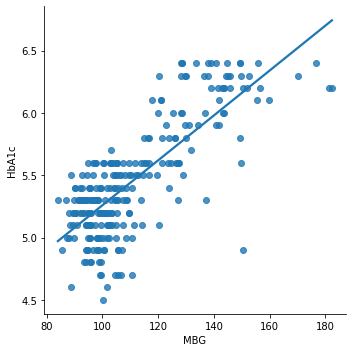

In [54]:
sns.lmplot(x="MBG",y="HbA1c",data=df,ci=None);